# Add variant annotations to gdata 

## Overview
This notebook demonstrates how to enhance the `gdata` object with variant annotations by running VEP on the variants present in `gdata` and shows how these annotations can be added to the `gdata` object. It also provides functionalities to aggregate variant consequences across different contexts (e.g., genes or transcripts) and includes methods to visualize the annotated variants.
All settings for VEP, such as the genome assembly or the species, can be set in `docs/configs/vep_config.yaml` or `docs/configs/vep_config_offline.yaml`. We recommend installing VEP via conda. If you want to use VEP in a Docker container, please follow these instructions:

1. Install Docker.
2. Install ensembl-vep via: `docker pull ensemblorg/ensembl-vep`
3. Update the `vep_command` in `vep_config.yaml` and `vep_config_offline.yaml` to: `docker run -v <base_path>:<base_path> -t ensemblorg/ensembl-vep vep` 


In [84]:
import cellink as cl
from pathlib import Path

In [79]:
package_dir = Path(cl.__file__).parent.parent.parent
gdata_path = package_dir / "tests/data/chr22.dose.filtered.R2_0.8.vcz"
vep_annotation_file = package_dir / "tests/data/variants_vep_annotated.txt"

## Load data as zarr file 

In [80]:
gdata = cl.io.read_sgkit_zarr(gdata_path)
print(gdata)
gdata.var

AnnData object with n_obs × n_vars = 1034 × 143083
    var: 'chrom', 'pos', 'a0', 'a1', 'AF', 'ER2', 'maf', 'R2', 'contig', 'id', 'id_mask', 'quality'
    varm: 'filter'


,chrom,pos,a0,a1,AF,ER2,maf,R2,contig,id,id_mask,quality
snp_id,,,,,,,,,,,,
22_16849573_A_G,22,16849573,A,G,0.39991,NaN,0.39991,0.85929,0,22:16849573,False,NaN
22_16849971_A_T,22,16849971,A,T,0.39455,NaN,0.39455,0.88142,0,22:16849971,False,NaN
22_16850437_G_A,22,16850437,G,A,0.38920,NaN,0.38920,0.90397,0,22:16850437,False,NaN
22_16851225_C_T,22,16851225,C,T,0.39466,NaN,0.39466,0.89089,0,22:16851225,False,NaN
22_16851356_C_T,22,16851356,C,T,0.38772,NaN,0.38772,0.90711,0,22:16851356,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
22_51202748_A_G,22,51202748,A,G,0.06811,NaN,0.06811,0.90748,0,22:51202748,False,NaN
22_51208568_G_T,22,51208568,G,T,0.06645,NaN,0.06645,0.86887,0,22:51208568,False,NaN
22_51211031_A_G,22,51211031,A,G,0.06472,NaN,0.06472,0.85566,0,22:51211031,False,NaN


In [81]:
gdata = gdata[:, :1000]  # subset to some variants to run the noteobook faster

## Write variants to VCF for annotation 

In [6]:
cl.io.write_variants_to_vcf(gdata, out_file=package_dir / "tests/data/variants.vcf")

[2025-03-23 15:17:35,143] INFO:cellink.io._export: number of variants to annotate: 1000
[2025-03-23 15:17:35,145] INFO:cellink.io._export: Writing variants to /data/nasif12/home_if12/hoev/git/sc-genetics/tests/data/variants.vcf


## Annotate variants

### Using VEP 
The example provided here used the online version of VEP which is relatively slow and has few plugins available. 

For running VEP offline and with plugins install the cache as explained in https://www.ensembl.org/info/docs/tools/vep/script/vep_cache.html#pre and relevant plugins and use 
`vep_config_offline.yaml`

In [88]:
! vep

#----------------------------------#
# ENSEMBL VARIANT EFFECT PREDICTOR #
#----------------------------------#

Versions:
  ensembl              : 112.e71cae3
  ensembl-funcgen      : 112.be19ffa
  ensembl-io           : 112.2851b6f
  ensembl-variation    : 112.4113356
  ensembl-vep          : 112.0

Help: dev@ensembl.org , helpdesk@ensembl.org
Twitter: @ensembl

http://www.ensembl.org/info/docs/tools/vep/script/index.html

Usage:
./vep [--cache|--offline|--database] [arguments]

Basic options

--help                 Display this message and quit

-i | --input_file      Input file
-o | --output_file     Output file
--force_overwrite      Force overwriting of output file
--species [species]    Species to use [default: "human"]

--everything           Shortcut switch to turn on commonly used options. See web
                       documentation for details [default: off]
--fork [num_forks]     Use forking to improve script runtime

For full option documentation see:
http://www.ensembl.or

In [82]:
vep_config = package_dir / "docs" / "configs" / "vep_config.yaml"

In [83]:
cl.tl.run_vep(
    vep_config, input_vcf=package_dir / "tests/data/variants.vcf", output=vep_annotation_file
)  # writes vep_annotation_file

[2025-03-23 16:07:34,955] INFO:cellink.tl._annotate_snps_genotype_data: using config /data/nasif12/home_if12/hoev/git/sc-genetics/docs/configs/vep_config.yaml
[2025-03-23 16:07:34,957] INFO:cellink.tl._annotate_snps_genotype_data: running VEP command vep --input_file /data/nasif12/home_if12/hoev/git/sc-genetics/tests/data/variants.vcf --output_file /data/nasif12/home_if12/hoev/git/sc-genetics/tests/data/variants_vep_annotated.txt --species homo_sapiens --assembly GRCh37 --format vcf --tab --fork 5 --pick_order biotype,canonical,appris,tsl,ccds,rank,length,ensembl,refseq --polyphen s --sift s --total_length --total_length --no_escape --canonical --protein --biotype --force_overwrite --no_stats --per_gene --database


[2025-03-23 16:08:13,927] INFO:cellink.tl._annotate_snps_genotype_data: VEP ran successfully!. Annotated variants are saved to /data/nasif12/home_if12/hoev/git/sc-genetics/tests/data/variants_vep_annotated.txt


### add VEP annos gdata 

In [28]:
cl.tl.add_vep_annos_to_gdata(vep_anno_file=vep_annotation_file, gdata=gdata, dummy_consequence=True)
gdata.uns["variant_annotation_vep"]

[2025-03-23 15:23:38,292] INFO:cellink.tl._annotate_snps_genotype_data: Preparing VEP annotations for addition to gdata
[2025-03-23 15:23:38,293] INFO:cellink.tl._annotate_snps_genotype_data: Reading annotation file /data/nasif12/home_if12/hoev/git/sc-genetics/tests/data/variants_vep_annotated.txt
[2025-03-23 15:23:38,298] INFO:cellink.tl._annotate_snps_genotype_data: Annotation file loaded
[2025-03-23 15:23:38,299] INFO:cellink.tl._annotate_snps_genotype_data: Annotation columns: ['snp_id', 'Location', 'Allele', 'gene_id', 'transcript_id', 'Feature_type', 'Consequence', 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 'Existing_variation', 'IMPACT', 'DISTANCE', 'STRAND', 'FLAGS', 'BIOTYPE', 'CANONICAL', 'ENSP', 'SIFT', 'PolyPhen']
[2025-03-23 15:23:38,313] INFO:cellink.tl._annotate_snps_genotype_data: Changing dtype of categorical columns ['snp_id', 'gene_id', 'transcript_id', 'CANONICAL', 'DISTANCE', 'BIOTYPE', 'STRAND', 'Codons', 'CDS_position', 'ENSP', 

[2025-03-23 15:23:38,324] INFO:cellink.tl._annotate_snps_genotype_data: VEP annotations added to gdata


/data/nasif12/home_if12/hoev/git/sc-genetics/src/cellink/tl/_annotate_snps_genotype_data.py:218: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  annos.replace("-", np.nan, inplace=True)


,,,Consequence_3_prime_UTR_variant,Consequence_5_prime_UTR_variant,Consequence_downstream_gene_variant,Consequence_intergenic_variant,Consequence_intron_variant,Consequence_missense_variant,Consequence_non_coding_transcript_exon_variant,Consequence_non_coding_transcript_variant,Consequence_splice_region_variant,Consequence_stop_gained,...,FLAGS,Codons,CDS_position,ENSP,Protein_position,IMPACT,cDNA_position,SIFT,PolyPhen,Amino_acids
snp_id,gene_id,transcript_id,,,,,,,,,,,,,,,,,,,,,
22_16849573_A_G,-,-,0,0,0,1,0,0,0,0,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
22_16849971_A_T,-,-,0,0,0,1,0,0,0,0,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
22_16850437_G_A,-,-,0,0,0,1,0,0,0,0,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
22_16851225_C_T,-,-,0,0,0,1,0,0,0,0,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
22_16851356_C_T,-,-,0,0,0,1,0,0,0,0,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22_17527240_G_A,ENSG00000237438,ENST00000441006,0,0,0,0,1,0,0,1,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
22_17527495_G_C,ENSG00000237438,ENST00000441006,0,0,0,0,1,0,0,1,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
22_17527847_C_T,ENSG00000237438,ENST00000441006,0,0,0,0,1,0,0,1,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-


### Combine annotations from different tools 

In [10]:
cl.tl.combine_annotations(gdata, ["vep"])
gdata

[2025-03-23 15:18:23,225] WARNING:cellink.tl._annotate_snps_genotype_data: Function still under development until it can be tested with other annotations


AnnData object with n_obs × n_vars = 1034 × 1000
    var: 'chrom', 'pos', 'a0', 'a1', 'AF', 'ER2', 'maf', 'R2', 'contig', 'id', 'id_mask', 'quality'
    uns: 'variant_annotation_vep', 'variant_annotation'
    varm: 'filter'

In [11]:
gdata.uns["variant_annotation"]

,,,Consequence_3_prime_UTR_variant,Consequence_5_prime_UTR_variant,Consequence_downstream_gene_variant,Consequence_intergenic_variant,Consequence_intron_variant,Consequence_missense_variant,Consequence_non_coding_transcript_exon_variant,Consequence_non_coding_transcript_variant,Consequence_splice_region_variant,Consequence_stop_gained,...,FLAGS,Codons,CDS_position,ENSP,Protein_position,IMPACT,cDNA_position,SIFT,PolyPhen,Amino_acids
snp_id,gene_id,transcript_id,,,,,,,,,,,,,,,,,,,,,
22_16849573_A_G,-,-,0,0,0,1,0,0,0,0,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
22_16849971_A_T,-,-,0,0,0,1,0,0,0,0,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
22_16850437_G_A,-,-,0,0,0,1,0,0,0,0,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
22_16851225_C_T,-,-,0,0,0,1,0,0,0,0,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
22_16851356_C_T,-,-,0,0,0,1,0,0,0,0,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22_17527240_G_A,ENSG00000237438,ENST00000441006,0,0,0,0,1,0,0,1,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
22_17527495_G_C,ENSG00000237438,ENST00000441006,0,0,0,0,1,0,0,1,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-
22_17527847_C_T,ENSG00000237438,ENST00000441006,0,0,0,0,1,0,0,1,0,0,...,NaN,-,-,-,-,MODIFIER,-,NaN,NaN,-


## Aggregate annotations across contexts to one row per variant to save as `uns`
We can have multiple annotation rows per variant, meaning that the variant overlaps different genes/transcripts. 
This is why the variant annotations are initially stored in `uns` since the number of rows is not equal to the number of variants. 
To be able to set the annotations as `varm`, one row per variant is needed. We provide different aggregation functions for this, including:

- `first`: Drops duplicates and keeps only the first occurrence for each variant-context pair. 
- `unique_list_max`: String annotations are aggregated into a comma-separated string per annotation, and numeric annotations are aggregated by their maximum value.


In [12]:
print(len(gdata.uns["variant_annotation_vep"].columns))
for agg_type in ["first", "unique_list_max"]:  # "list", "str"]:
    res = cl.tl.aggregate_annotations_for_varm(gdata, "variant_annotation_vep", agg_type=agg_type, return_data=True)
    print(len(res))
    print(len(res.columns))
gdata

27
[2025-03-23 15:18:31,790] INFO:cellink.tl._annotate_snps_genotype_data: Aggregating using method: first
1000
29
[2025-03-23 15:18:31,794] INFO:cellink.tl._annotate_snps_genotype_data: Aggregating using method: unique_list_max
[2025-03-23 15:18:31,804] INFO:cellink.tl._annotate_snps_genotype_data: Columns to aggregate: ['gene_id', 'transcript_id', 'Consequence_5_prime_UTR_variant', 'Consequence_downstream_gene_variant', 'Consequence_intron_variant', 'Consequence_non_coding_transcript_exon_variant', 'Consequence_non_coding_transcript_variant', 'Consequence_upstream_gene_variant', 'CANONICAL', 'DISTANCE', 'BIOTYPE', 'STRAND', 'ENSP', 'cDNA_position']


1000
29


AnnData object with n_obs × n_vars = 1034 × 1000
    var: 'chrom', 'pos', 'a0', 'a1', 'AF', 'ER2', 'maf', 'R2', 'contig', 'id', 'id_mask', 'quality'
    uns: 'variant_annotation_vep', 'variant_annotation'
    varm: 'filter', 'variant_annotation'

In [13]:
cl.tl.aggregate_annotations_for_varm(gdata, "variant_annotation_vep", agg_type="unique_list_max", return_data=True)

[2025-03-23 15:18:33,342] INFO:cellink.tl._annotate_snps_genotype_data: Aggregating using method: unique_list_max
[2025-03-23 15:18:33,350] INFO:cellink.tl._annotate_snps_genotype_data: Columns to aggregate: ['gene_id', 'transcript_id', 'Consequence_5_prime_UTR_variant', 'Consequence_downstream_gene_variant', 'Consequence_intron_variant', 'Consequence_non_coding_transcript_exon_variant', 'Consequence_non_coding_transcript_variant', 'Consequence_upstream_gene_variant', 'CANONICAL', 'DISTANCE', 'BIOTYPE', 'STRAND', 'ENSP', 'cDNA_position']


,Amino_acids,BIOTYPE,CANONICAL,CDS_position,Codons,Consequence_3_prime_UTR_variant,Consequence_5_prime_UTR_variant,Consequence_downstream_gene_variant,Consequence_intergenic_variant,Consequence_intron_variant,...,Existing_variation,FLAGS,IMPACT,PolyPhen,Protein_position,SIFT,STRAND,cDNA_position,gene_id,transcript_id
snp_id,,,,,,,,,,,,,,,,,,,,,
22_16849573_A_G,-,-,-,-,-,0,0,0,1,0,...,NaN,NaN,MODIFIER,NaN,-,NaN,NaN,-,-,-
22_16849971_A_T,-,-,-,-,-,0,0,0,1,0,...,NaN,NaN,MODIFIER,NaN,-,NaN,NaN,-,-,-
22_16850437_G_A,-,-,-,-,-,0,0,0,1,0,...,NaN,NaN,MODIFIER,NaN,-,NaN,NaN,-,-,-
22_16851225_C_T,-,-,-,-,-,0,0,0,1,0,...,NaN,NaN,MODIFIER,NaN,-,NaN,NaN,-,-,-
22_16851356_C_T,-,-,-,-,-,0,0,0,1,0,...,NaN,NaN,MODIFIER,NaN,-,NaN,NaN,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22_17527240_G_A,-,lincRNA,YES,-,-,0,0,0,0,1,...,NaN,NaN,MODIFIER,NaN,-,NaN,1.0,-,ENSG00000237438,ENST00000441006
22_17527495_G_C,-,lincRNA,YES,-,-,0,0,0,0,1,...,NaN,NaN,MODIFIER,NaN,-,NaN,1.0,-,ENSG00000237438,ENST00000441006
22_17527847_C_T,-,lincRNA,YES,-,-,0,0,0,0,1,...,NaN,NaN,MODIFIER,NaN,-,NaN,1.0,-,ENSG00000237438,ENST00000441006


In [15]:
gdata.varm["variant_annotation"].query('BIOTYPE == "protein_coding"')

,Amino_acids,BIOTYPE,CANONICAL,CDS_position,Codons,Consequence_3_prime_UTR_variant,Consequence_5_prime_UTR_variant,Consequence_downstream_gene_variant,Consequence_intergenic_variant,Consequence_intron_variant,...,Existing_variation,FLAGS,IMPACT,PolyPhen,Protein_position,SIFT,STRAND,cDNA_position,gene_id,transcript_id
snp_id,,,,,,,,,,,,,,,,,,,,,
22_17069064_T_A,-,protein_coding,YES,-,-,0,0,1,0,0,...,NaN,NaN,MODIFIER,NaN,-,NaN,-1.0,-,ENSG00000198445,ENST00000359963
22_17069391_G_A,-,protein_coding,YES,-,-,0,0,1,0,0,...,NaN,NaN,MODIFIER,NaN,-,NaN,-1.0,-,ENSG00000198445,ENST00000359963
22_17070109_A_G,-,protein_coding,YES,-,-,0,0,1,0,0,...,NaN,NaN,MODIFIER,NaN,-,NaN,-1.0,-,ENSG00000198445,ENST00000359963
22_17070764_C_G,-,protein_coding,YES,-,-,0,0,1,0,0,...,NaN,NaN,MODIFIER,NaN,-,NaN,-1.0,-,ENSG00000198445,ENST00000359963
22_17265124_A_C,F/L,protein_coding,YES,765/1380,ttT/ttG,0,0,0,0,0,...,NaN,NaN,MODERATE,0.0,255/459,1.0,-1.0,868/1690,ENSG00000172967,ENST00000331428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22_17487338_C_T,-,protein_coding,YES,-,-,0,0,0,0,1,...,NaN,NaN,MODIFIER,NaN,-,NaN,-1.0,-,ENSG00000215568,ENST00000400588
22_17487476_G_A,-,protein_coding,YES,-,-,0,0,0,0,1,...,NaN,NaN,MODIFIER,NaN,-,NaN,-1.0,-,ENSG00000215568,ENST00000400588
22_17488026_G_C,-,protein_coding,YES,-,-,0,0,0,0,1,...,NaN,NaN,MODIFIER,NaN,-,NaN,-1.0,-,ENSG00000215568,ENST00000400588


## Test writing

In [ ]:
gdata.uns.pop("variant_annotation_vep", None)  # hast to be dropped because of multiindex before writing
gdata.uns.pop("variant_annotation", None)  # hast to be dropped because of multiindex before writing
gdata.write("gdata.h5ad")  # test

## Explore/Plot annotations

In [42]:
gdata.varm["variant_annotation"].columns

Index(['Amino_acids', 'BIOTYPE', 'CANONICAL', 'CDS_position', 'Codons',
       'Consequence_3_prime_UTR_variant', 'Consequence_5_prime_UTR_variant',
       'Consequence_downstream_gene_variant', 'Consequence_intergenic_variant',
       'Consequence_intron_variant', 'Consequence_missense_variant',
       'Consequence_non_coding_transcript_exon_variant',
       'Consequence_non_coding_transcript_variant',
       'Consequence_splice_region_variant', 'Consequence_stop_gained',
       'Consequence_synonymous_variant', 'Consequence_upstream_gene_variant',
       'DISTANCE', 'ENSP', 'Existing_variation', 'FLAGS', 'IMPACT', 'PolyPhen',
       'Protein_position', 'SIFT', 'STRAND', 'cDNA_position', 'gene_id',
       'transcript_id'],
      dtype='object')

array([[<Axes: title={'center': 'PolyPhen'}>]], dtype=object)

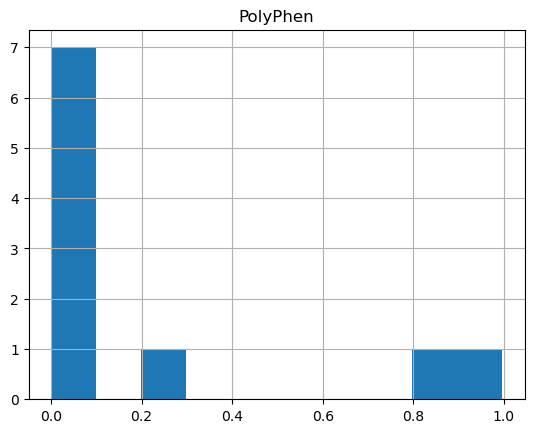

In [43]:
gdata.varm["variant_annotation"].query('BIOTYPE == "protein_coding"')[["PolyPhen"]].hist()

<Axes: xlabel='IMPACT'>

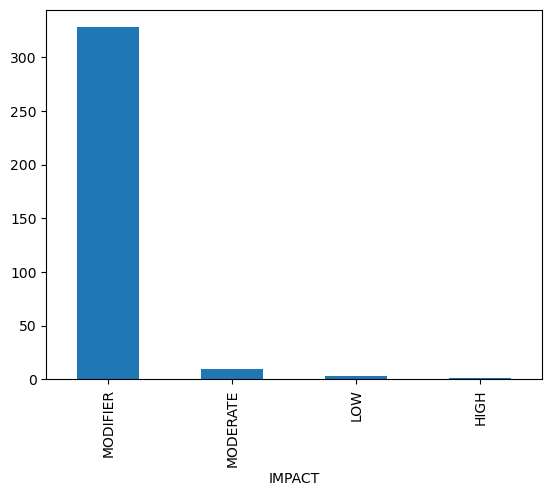

In [46]:
gdata.varm["variant_annotation"].query('BIOTYPE == "protein_coding"')["IMPACT"].value_counts().plot(kind="bar")

In [48]:
consequence_cols = [col for col in gdata.varm["variant_annotation"].columns if "Consequence" in col]

<Axes: >

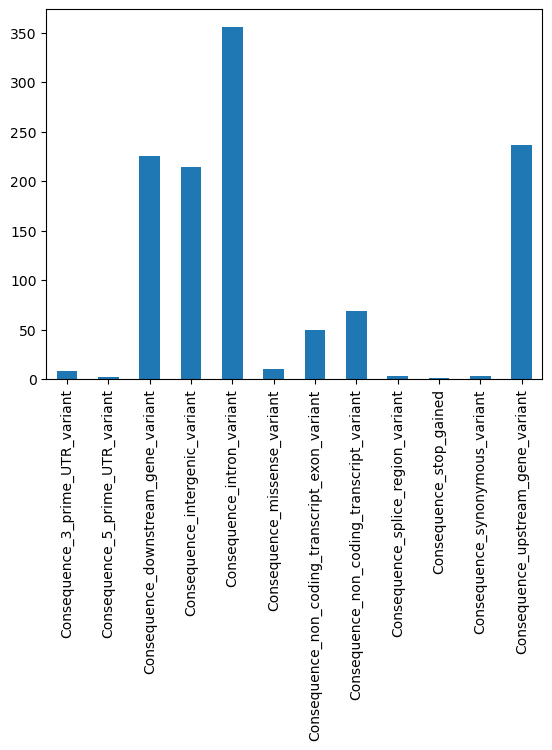

In [50]:
gdata.varm["variant_annotation"][consequence_cols].sum().plot(kind="bar")